In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap
import pandas as pd
sys.path.append('../')
from hamiltonian import *
from parameters import *

old_settings = np.seterr(divide='ignore', invalid='ignore') # Necessary to suppress warnings for low T

Orbital relaxation time as a function of strain and temperature

In [2]:
# Find magnitude of B-field needed for qubit frequency at given B-field angle
i_defect = 0 # model SiV
H, _, _ = create_hamiltonian()

alpha = np.linspace(0, 6*Ls[i_defect], 200)
B = np.linspace(0, 50, 300)
theta = np.linspace(0, 90, 200)*np.pi/180
alphaH, BH, thetaH, _ = tensor_repeat(alpha, B, theta, np.zeros((4,4)))

BHx = BH*np.sin(thetaH)
BHz = BH*np.cos(thetaH)

f_target = 2.75 # [GHz] Target qubit frequency
BH = target_frequency_parameters(f_target, BH, 1, BHx, 0, BHz, qs[i_defect], Ls[i_defect], alphaH, 0)

# Re-calculate eigenvalues
BH, _ = tensor_repeat(BH, np.zeros((4,4)))
alphaH = alphaH[:,0,:]
thetaH = thetaH[:,0,:]
BHx = BH*np.sin(thetaH)
BHz = BH*np.cos(thetaH)

Hgiv = H(BHx, 0, BHz, qs[i_defect], Ls[i_defect], alphaH, 0)
E, U = np.linalg.eigh(Hgiv)
E_Q, E_orb, lambda_eff = diagonalised_hamiltonian_parameters( E )


In [3]:
# Reshape variables
T = np.linspace(0.1, 25, 110)

alphaH, thetaH, TH, _ = tensor_repeat( alpha, theta, T, np.zeros((4,4)) )
BH, _, _ = tensor_repeat( BH[...,0,0], T, np.zeros((4,4)))
BHx = BH*np.sin(thetaH)
BHz = BH*np.cos(thetaH)
Hgiv = H(BHx, 0, BHz, qs[i_defect], Ls[i_defect], alphaH, 0)
E, U = np.linalg.eigh(Hgiv)

In [4]:
# Calculate SiV spin T2

Nchi = 4
chi_factor = 0.9

gamma_T1 = [None]*Nchi
gamma_T2 = [None]*Nchi
gammaOrb = [None]*Nchi

for i in range(3):
    gamma_T1[i], gamma_T2[i], gammaOrb[i] = calculate_gamma(E, U, chi_err[i,i_defect], TH)

gamma_T1[3], gamma_T2[3], gammaOrb[3] = calculate_gamma(E, U, chi_err[0,i_defect]*chi_factor, TH)

gamma_T1 = np.array(gamma_T1)
gamma_T2 = np.array(gamma_T2)
gammaOrb = np.array(gammaOrb)

lambda_eff, _ = tensor_repeat( lambda_eff, T )
T2_corr = T_eff_approx( 0.5*gamma_T1, 0.5*gammaOrb, lambda_eff*1e9 )

In [5]:
# Calculate orbital T1 w/out b-field
alphaH, TH, _ = tensor_repeat( alpha, T, np.zeros((4,4)) )
Hgiv = H(0, 0, 1e-9, qs[i_defect], Ls[i_defect], alphaH, 0)
E, U = np.linalg.eigh(Hgiv)

gamma_T1_orb = [calculate_orbital_gamma(E, U, chi_err[i,i_defect], TH) for i in range(3)]
gamma_T1_orb.append( calculate_orbital_gamma(E, U, chi_err[0,i_defect]*chi_factor, TH))
gamma_T1_orb = np.array(gamma_T1_orb)

Caclulate coherence including degenerate transition correction

Compare to $T_{1/2}^{Q}$ measured in of [Pingault et al. (2017)](https://www.nature.com/articles/ncomms15579)

In [10]:
def plot_comparison(data, ax, markers, makersizes, colors):

    for i, T in enumerate(data['Type of T'].unique()):

        for j, source in enumerate(data['Source'].unique()):
            ax.errorbar(data[(data['Type of T']==T) & (data['Source']==source)]['Measured T (ns)'],
                        data[(data['Type of T']==T) & (data['Source']==source)]['Theory T (ns)'],
                        [data[(data['Type of T']==T) & (data['Source']==source)]['Theory T + error (ns)'],
                        data[(data['Type of T']==T) & (data['Source']==source)]['Theory T - error (ns)']],
                        [data[(data['Type of T']==T) & (data['Source']==source)]['Measured T + error (ns)'],
                        data[(data['Type of T']==T) & (data['Source']==source)]['Measured T - error (ns)']], fmt=markers[i], barsabove=False, zorder=2, capsize=None, markerfacecolor=colors[j], markersize=makersizes[i], elinewidth=1, ecolor='k', markeredgewidth=0.2, markeredgecolor='k')
    plt.xlabel('Measured (ns)')

def re_scale_ax(ax):
    ax.set_yscale('log')
    ax.set_xscale('log')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = np.array( [ min(xlim[0], ylim[0]), max(xlim[1], ylim[1]) ] )
    ax.plot( lim, lim, 'k--', zorder=1 )
    #ax.fill_between( lim, 0.7*lim, 1.3*lim, zorder=0, color='grey', alpha=0.1)
    ax.set_ylim(lim)
    ax.set_xlim(lim)

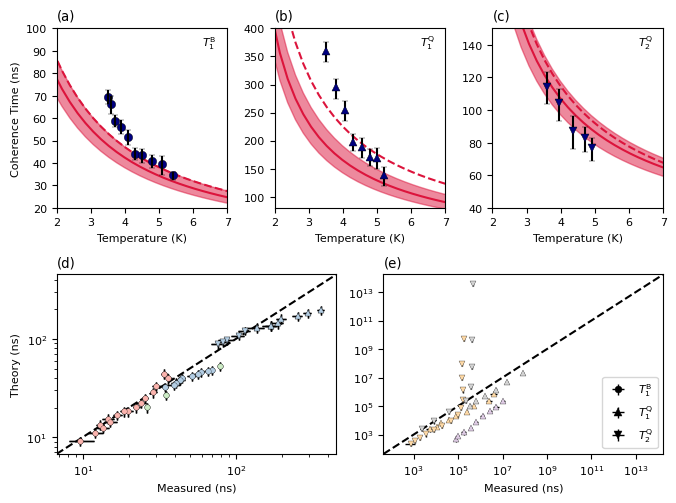

In [12]:
# Plot vs predicted
# Load Pingault data
data = []
predicted = []

tmp = np.genfromtxt("Data/Pingault2017_orbital_T1.csv", delimiter=',', encoding="utf_8_sig")
tmp = tmp.T
tmp[1:,:] = 1/(2*tmp[1:,:]*1e-3)
tmp[2:,:] = np.abs( tmp[2:,:] - tmp[1,:] )
data.append(tmp)
predicted.append(np.zeros_like(tmp, dtype='object'))

tmp = np.genfromtxt("Data/Pingault2017_spin_T1.csv", delimiter=',', encoding="utf_8_sig")
tmp = tmp.T
tmp[1:,:] = 1/(2*tmp[1:,:]*1e-3)
tmp[2:,:] = np.abs( tmp[2:,:] - tmp[1,:] )
data.append(tmp)
predicted.append(np.zeros_like(tmp, dtype='object'))

tmp = np.genfromtxt("Data/Pingault2017_spin_T2.csv", delimiter=',', encoding="utf_8_sig")
tmp = tmp.T
tmp[1:,:] = 1/(tmp[1:,:]*1e-3)
tmp[2:,:] = np.abs( tmp[2:,:] - tmp[1,:] )
data.append(tmp)
predicted.append(np.zeros_like(tmp, dtype='object'))

# Configure plot
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(2*3.38583, 1.5*3.38583))
gs = plt.GridSpec(ncols=6, nrows=2)

# Plots for Pingault et al.
labels = ['Exp.: Pingault et al. (2017)']
i_alpha = np.argmin( np.abs(alpha - 12) )
theta_target = 109.5
i_theta = np.argmin( np.abs(theta-(180-theta_target)*np.pi/180) )
i_thetap = np.argmin( np.abs(theta-(180-theta_target-1)*np.pi/180) )
i_thetam = np.argmin( np.abs(theta-(180-theta_target+1)*np.pi/180) )
i_theta_extreme = np.argmin( np.abs(theta-(180-114.5)*np.pi/180) )

# Plot orbital T1
j=0
plt.subplot(gs[0,:2])

alpha_exp = alpha[i_alpha]

plt.plot( T, 1e9/gamma_T1_orb[0,i_alpha, :], 'crimson', label=r'Theory $\alpha=$' + f'{alpha_exp:.0f} GHz', zorder=1)
plt.fill_between( T, 1e9/gamma_T1_orb[1,i_alpha, :], 1e9/gamma_T1_orb[2,i_alpha, :], color='crimson', alpha=0.5, zorder=0)
plt.plot( T, 1e9/gamma_T1_orb[3,i_alpha, :], 'crimson', linestyle='--', label=r'Theory $\alpha=$' + f'{alpha_exp:.0f} GHz', zorder=1)

plt.errorbar( data[j][0,:], data[j][1,:], data[0][2:,:], fmt='o', barsabove=True, markerfacecolor='navy', label=labels[0], zorder=2, capsize=2, ecolor='k', markeredgewidth=0.3, markeredgecolor='k')

plt.xlim( 2, 7 )
plt.xlabel( 'Temperature (K)')
ylims = ( 20, 100 )
plt.ylim( *ylims )

plt.ylabel( 'Coherence Time (ns)' )
plt.title('(a)', loc='left')
xloc = 6.25
yfrac = .9
plt.text( xloc, ylims[0] + (ylims[1] - ylims[0])*yfrac, r'$T_1^\mathrm{B}$')

# Plot T1
j=1
plt.subplot(gs[0,2:4])

alpha_exp = alpha[i_alpha]

plt.plot( T, 1e9/gamma_T1[0,i_alpha, i_theta, :], 'crimson', label=r'Theory $\alpha=$' + f'{alpha_exp:.0f} GHz', zorder=1)
plt.fill_between( T, 1e9/gamma_T1[1,i_alpha, i_thetap, :], 1e9/gamma_T1[2,i_alpha, i_thetam, :], color='crimson', alpha=0.5, zorder=0)
plt.plot( T, 1e9/gamma_T1[3,i_alpha, i_theta_extreme, :], 'crimson', linestyle='--', label=r'Theory $\alpha=$' + f'{alpha_exp:.0f} GHz', zorder=1)

plt.errorbar( data[j][0,:], data[j][1,:], data[j][2:,:], fmt='^', barsabove=False, markerfacecolor='navy', label=labels[0], zorder=2, capsize=2, ecolor='k', markeredgewidth=0.3, markeredgecolor='k')

i_T = [ np.argmin(np.abs(data[j][0,i] - T)) for i in range(data[j][0,:].size) ]
predicted[j][0:-1,:] = np.array([1e9/gamma_T1[0,i_alpha, i_thetap, i_T], 1e9/gamma_T1[1,i_alpha, i_thetap, i_T], 1e9/gamma_T1[2,i_alpha, i_thetap, i_T]])
predicted[j][-1,:] = labels[0]

plt.xlim( 2, 7 )
plt.xlabel( 'Temperature (K)')
ylims = ( 80, 400 )
plt.ylim( *ylims )

plt.text( xloc, ylims[0] + (ylims[1] - ylims[0])*yfrac, r'$T_1^\mathrm{Q}$')
plt.title('(b)', loc='left')

# Plot T2
j=2
plt.subplot(gs[0,4:])

alpha_exp = alpha[i_alpha]

plt.plot( T, 1e9*T2_corr[0,i_alpha, i_theta, :], 'crimson', label=r'Theory $\alpha=$' + f'{alpha_exp:.0f} GHz', zorder=1)
plt.fill_between( T, 1e9*T2_corr[1,i_alpha, i_theta, :], 1e9*T2_corr[2,i_alpha, i_theta, :], color='crimson', alpha=0.5, zorder=0)
plt.plot( T, 1e9*T2_corr[3,i_alpha, i_theta_extreme, :], 'crimson', linestyle='--', label=r'Theory $\alpha=$' + f'{alpha_exp:.0f} GHz', zorder=1)

plt.errorbar( data[j][0,:], data[j][1,:], data[j][2:,:], fmt='v', barsabove=False, markerfacecolor='navy', label=labels[0], zorder=2, capsize=2, ecolor='k', markeredgewidth=0.3, markeredgecolor='k')


i_T = [ np.argmin(np.abs(data[j][0,i] - T)) for i in range(data[j][0,:].size) ]
predicted[j][0:-1,:] = np.array([1e9*T2_corr[0,i_alpha, i_theta, i_T], 1e9*T2_corr[1,i_alpha, i_theta, i_T], 1e9*T2_corr[2,i_alpha, i_theta, i_T]])
predicted[j][-1,:] = labels[0]

plt.xlim( 2, 7 )
plt.xlabel( 'Temperature (K)')
ylims = (40, 150)
plt.ylim( *ylims )

plt.text( xloc, ylims[0] + (ylims[1] - ylims[0])*yfrac, r'$T_2^\mathrm{Q}$')
plt.title('(c)', loc='left')

# Plot full comparisons
cm = get_cmap('Pastel1')
markers = ['^', 'v']
markersizes = [5, 5]

# Plot SiV
ax = plt.subplot(gs[1,0:3])

data = pd.read_csv("Data/SiV_orbital_T1.csv")
data = pd.concat( [data, pd.read_csv("Data/SiV_orbital_T1.csv")], axis=0 )
plot_comparison(data, ax, ['o'], [4], [cm(0), cm(1), cm(2)])

data = pd.read_csv("Data/SiV_qubit_T.csv")
data = pd.concat( [data, pd.read_csv("Data/SiV_qubit_T.csv")], axis=0 )
plot_comparison(data, ax, markers, markersizes, [cm(1)])

plt.title('(d)', loc='left')
re_scale_ax(ax)
plt.ylabel('Theory (ns)')

# SnV
ax = plt.subplot(gs[1,3:])

data = pd.read_csv("Data/SnV_qubit_T.csv")
plot_comparison(data, ax, markers, markersizes, [cm(3), cm(4), 'lightgrey'])

plt.title('(e)', loc='left')
re_scale_ax(ax)

ax.errorbar( 1, 1, 1, 1, fmt='o', barsabove=True, label=r'$T_1^\mathrm{B}$', zorder=2, capsize=None, color='k', markersize=5, elinewidth=1, ecolor='k', markeredgewidth=0.3, markeredgecolor='k')
ax.errorbar( 1, 1, 1, 1, fmt='^', barsabove=True, label=r'$T_1^\mathrm{Q}$', zorder=2, capsize=None, color='k', markersize=6, elinewidth=1, ecolor='k', markeredgewidth=0.3, markeredgecolor='k')
ax.errorbar( 1, 1, 1, 1, fmt='v', barsabove=True, label=r'$T_2^\mathrm{Q}$', zorder=2, capsize=None, color='k', markersize=6, elinewidth=1, ecolor='k', markeredgewidth=0.3, markeredgecolor='k')
plt.legend(loc='lower right')

gs.tight_layout(fig)

plt.savefig('Fig3_Experiment.pdf', dpi=600)
plt.show()